# Setup
[Copied from different ipynbs](https://www.neelnanda.io/mechanistic-interpretability/quickstart)


In [ ]:
try:
    import google.colab # type: ignore
    IN_COLAB = True
except:
    IN_COLAB = False

import os, sys

if IN_COLAB:
    # Install packages
    %pip install einops
    %pip install jaxtyping
    %pip install transformer_lens
    %pip install -U pandas plotly
else:
    from IPython import get_ipython
    ipython = get_ipython()
    ipython.run_line_magic("load_ext", "autoreload")
    ipython.run_line_magic("autoreload", "2")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.2/189.2 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.8/20.8 MB 92.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 62.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.6/207.6 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.3 MB/s eta 0:00:00
 

In [ ]:
import os; os.environ["ACCELERATE_DISABLE_RICH"] = "1"
import torch
from torch import Tensor
import numpy as np
import einops
from tqdm.notebook import tqdm
import webbrowser
import re
import itertools
import time
from jaxtyping import Float, Int, Bool
from typing import List, Optional, Callable, Tuple, Dict, Literal, Set
from functools import partial
from IPython.display import display, HTML
import plotly.express as px
import plotly.io as pio
from rich.table import Table, Column
from rich import print as rprint
from pathlib import Path
from transformer_lens.hook_points import HookPoint
from transformer_lens import utils, HookedTransformer, ActivationCache, HookedTransformerConfig, patching, FactoredMatrix
from transformer_lens.components import Embed, Unembed, LayerNorm, MLP
import seaborn as sns
import matplotlib.pyplot as plt

torch.set_grad_enabled(False)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

MAIN = __name__ == "__main__"

# Task

What am I trying to do and what questions I hope to asnwer: relation between superposition and decline in long range repsonse
1. Correspondence between limits of superposition(features(model) > basis(model)) and linearity in GPT2 in terms of JL lemma.
2. Is the level of superposition same across layers? (Rank of superposition, ratio of model dimension to this rank)?
3. Superposition, in terms of the rank of the neuronal values immediately before the activation (residual stream information has been shown to be low rank because [this](https://openreview.net/pdf?id=LUsx0chTsL)), is same as the rank of superposition after activaiton and before going into the residual stream?
4. If superposition is such a fundamental property of neurons, to what extent is it maintained in the SAE \\
    4.1 Correlation between the latent representations by SAE when the input are the neurons activation vs when they are the neurons output before the activation


In [ ]:
#100 tokens
smalltext = """Artificial intelligence is transforming the way we interact with technology. From chatbots to self-driving cars,
AI is making systems smarter and more efficient. Large language models like GPT-2 and GPT-3
have demonstrated remarkable capabilities in text generation, translation, and even coding tasks. These models
rely on vast datasets and deep learning techniques to produce human-like responses. Despite their strengths,
challenges such as bias, interpretability, and ethical concerns remain significant. Researchers continue to explore
ways to make AI more transparent and reliable. The future of AI holds immense potential for innovation across industries,
from healthcare to finance and beyond. """


#500 tokens
largetext = """Global Warming: Causes, Effects, and Solutions
Global warming refers to the long-term increase in Earth's average surface temperature due to human activities, primarily the burning of fossil fuels. This process releases greenhouse gases like carbon dioxide (CO₂), methane (CH₄), and nitrous oxide (N₂O) into the atmosphere. These gases trap heat, leading to a rise in global temperatures, a phenomenon known as the greenhouse effect.
Causes of Global Warming
One of the primary causes of global warming is the excessive use of fossil fuels such as coal, oil, and natural gas. These energy sources are used for electricity generation, transportation, and industrial processes. As populations grow, so does the demand for energy, leading to more emissions.
Deforestation also contributes significantly to climate change. Trees absorb CO₂, helping to balance atmospheric carbon levels. However, large-scale deforestation, especially in tropical rainforests like the Amazon, reduces this natural carbon sink. As a result, more CO₂ remains in the air, accelerating warming.
Agriculture is another major contributor. Livestock, especially cattle, produce methane during digestion. Additionally, the use of synthetic fertilizers releases nitrous oxide, a potent greenhouse gas. Industrial waste, excessive plastic production, and overreliance on non-renewable resources further worsen the situation.
Effects of Global Warming
The consequences of rising temperatures are already visible worldwide. Ice caps and glaciers are melting, leading to rising sea levels. Coastal cities like Miami, Jakarta, and Venice face an increasing risk of flooding, displacing millions. Small island nations, such as the Maldives, are at risk of disappearing entirely.
Extreme weather events, such as hurricanes, heatwaves, wildfires, and droughts, have become more frequent and severe. In 2023 alone, record-breaking heatwaves in Europe and North America caused thousands of deaths. Wildfires in Australia, California, and Greece destroyed millions of acres of forests, contributing to further CO₂ emissions.
Conclusion
Global warming is one of the biggest challenges of our time. Its effects are widespread, impacting ecosystems, weather patterns, and human health. While progress is being made, immediate and sustained efforts are essential. Governments, businesses, and individuals must work together to reduce emissions, protect the environment, and create a sustainable future for generations to come. """


# Experiment 1

Let m be the latent dimension, n be the dataset features
"""
the OG article on superposition says `` The final step is whether to add
an activation function. This turns out to be critical to whether
superposition occurs. In a real neural network, when features are actually used by the model to do
computation, there will be an activation function, so it seems principled to include one at the end. ``


Since features are sparse, sample a few datasets and see what is value of superposition (neuron dimension/number of active features) for each of
those datasets, check if the average of neuron dimension and the avergae of active features over all examples, is close to the limit
put forth by JL lemma.
"""

In [ ]:
model = HookedTransformer.from_pretrained("gpt2-small")

tokens = model.to_tokens(smalltext).to(model.cfg.device)
n_tokens = tokens.shape[-1]
print("n_tokens",n_tokens)

#original_logits, cache = model.run_with_cache(tokens)

# Initialize experiment values
drop_levels = torch.linspace(0.1, 0.7, 10)
actdict = [{} for _ in range(len(drop_levels))]

begin = time.time()
for i in range(len(drop_levels)):
    drop_mask = torch.rand(n_tokens, device=model.cfg.device) > drop_levels[i]
    dropped_tokens = tokens.clone()
    dropped_tokens[:, ~drop_mask] = model.tokenizer.pad_token_id  # Replace with padding
    print("drop_mask numbers",torch.sum(drop_mask).item())
    original_logits, cache = model.run_with_cache(dropped_tokens)
    for layer in [0, 6, 11]:
      actdict[i][f"layer{layer}"] = cache[f'blocks.{layer}.mlp.hook_post']
    actdict[i][f"finlayer"] = cache[f'ln_final.hook_normalized']
print(f"time taken {(time.time()-begin):.6f}")

def correlation_matrix(W):
    """Computes a token-token correlation matrix."""
    W_flat = W.squeeze(0).detach().cpu().numpy()  # Shape: (tokens, hidden_dim)
    corr_mat = np.corrcoef(W_flat)  # Shape: (tokens, tokens)
    return torch.tensor(corr_mat, dtype=torch.float32)

#calculate plotting values
layer0y, layer6y, layer11y, layerfin = [],[],[],[]
for i in range(len(drop_levels)):
  layer0y.append(torch.norm(correlation_matrix(actdict[i]["layer0"]), p="fro"))
  layer6y.append(torch.norm(correlation_matrix(actdict[i]["layer6"]), p="fro"))
  layer11y.append(torch.norm(correlation_matrix(actdict[i]["layer11"]), p="fro"))
  layerfin.append(torch.norm(correlation_matrix(actdict[i]["finlayer"]), p="fro"))


Loaded pretrained model gpt2-small into HookedTransformer
n_tokens 139
drop_mask numbers 128
drop_mask numbers 117
drop_mask numbers 92
drop_mask numbers 99
drop_mask numbers 86
drop_mask numbers 85
drop_mask numbers 69
drop_mask numbers 70
drop_mask numbers 56
drop_mask numbers 40
time taken 22.300678


In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=drop_levels, y=layer0y, mode="lines", name="Layer 0"))
fig.add_trace(go.Scatter(x=drop_levels, y=layer6y, mode="lines", name="Layer 6"))
fig.add_trace(go.Scatter(x=drop_levels, y=layer11y, mode="lines", name="Layer 11"))
fig.add_trace(go.Scatter(x=drop_levels, y=layerfin, mode="lines", name="Layer output"))

fig.update_layout(
    title="Verifying JL lemma for about a 100 tokens",
    xaxis_title="Drop ratio",
    yaxis_title="norm of MLP correlation",
    legend_title="Layers",
    height=500, width=700
)

# Show figure
pio.show(fig)

<ipython-input-34-bd0a8bd02c98>:41: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



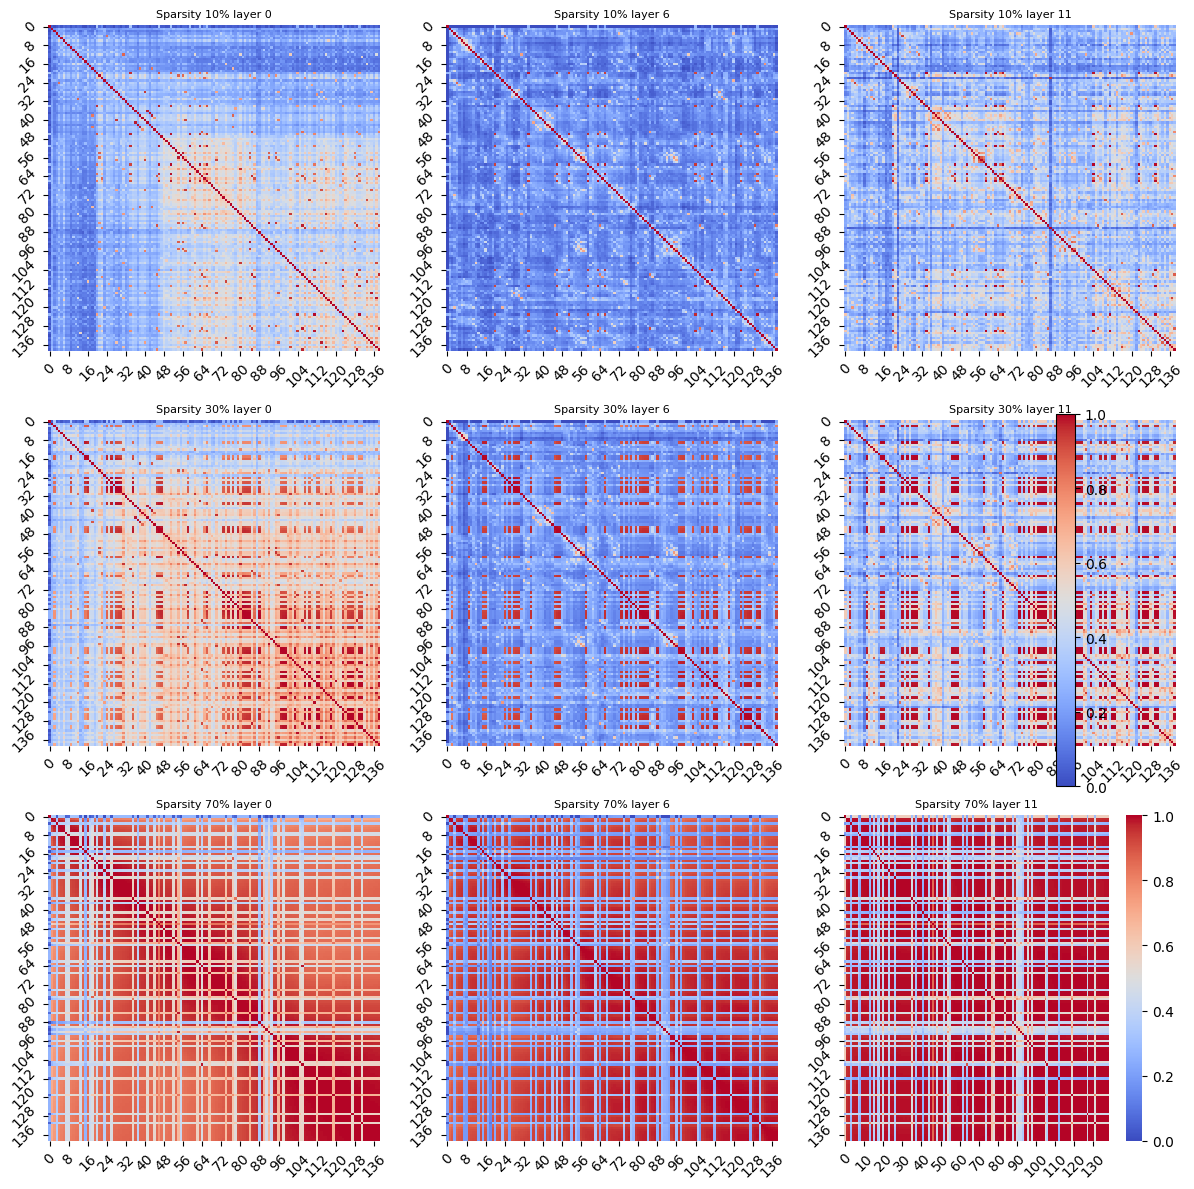

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

# Set a common color map
cmap = 'coolwarm'  # You can use any colormap like 'viridis', 'plasma', etc.

# Set the color scale range for all plots (same vmin and vmax)
vmin = 0
vmax = 1

# Plot each heatmap on a different axis
sns.heatmap(correlation_matrix(actdict[0]["layer0"]), ax=axes[0, 0], cmap=cmap, vmin=vmin, vmax=vmax, cbar=False)
axes[0, 0].set_title('Sparsity 10% layer 0', fontsize=8)
sns.heatmap(correlation_matrix(actdict[0]["layer6"]), ax=axes[0, 1], cmap=cmap, vmin=vmin, vmax=vmax, cbar=False)
axes[0, 1].set_title('Sparsity 10% layer 6', fontsize=8)
sns.heatmap(correlation_matrix(actdict[0]["layer11"]), ax=axes[0, 2], cmap=cmap, vmin=vmin, vmax=vmax, cbar=False)
axes[0, 2].set_title('Sparsity 10% layer 11', fontsize=8)
sns.heatmap(correlation_matrix(actdict[3]["layer0"]), ax=axes[1, 0], cmap=cmap, vmin=vmin, vmax=vmax, cbar=False)
axes[1, 0].set_title('Sparsity 30% layer 0', fontsize=8)
sns.heatmap(correlation_matrix(actdict[3]["layer6"]), ax=axes[1, 1], cmap=cmap, vmin=vmin, vmax=vmax, cbar=False)
axes[1, 1].set_title('Sparsity 30% layer 6', fontsize=8)
sns.heatmap(correlation_matrix(actdict[3]["layer11"]), ax=axes[1, 2], cmap=cmap, vmin=vmin, vmax=vmax, cbar=False)
axes[1, 2].set_title('Sparsity 30% layer 11', fontsize=8)
sns.heatmap(correlation_matrix(actdict[9]["layer0"]), ax=axes[2, 0], cmap=cmap, vmin=vmin, vmax=vmax, cbar=False)
axes[2, 0].set_title('Sparsity 70% layer 0', fontsize=8)
sns.heatmap(correlation_matrix(actdict[9]["layer6"]), ax=axes[2, 1], cmap=cmap, vmin=vmin, vmax=vmax, cbar=False)
axes[2, 1].set_title('Sparsity 70% layer 6', fontsize=8)
sns.heatmap(correlation_matrix(actdict[9]["layer11"]), ax=axes[2, 2], cmap=cmap, vmin=vmin, vmax=vmax)
axes[2, 2].set_title('Sparsity 70% layer 11', fontsize=8)

# Add colorbars to each subplot
for ax in axes.flat:
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=45)

# Add a single colorbar to the figure
fig.colorbar(axes[2, 2].collections[0], ax=axes, orientation='vertical', fraction=0.02, pad=0.04)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()
plt.savefig("first.png")

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=np.log(drop_levels), y=layer0y, mode="lines", name="Layer 0"))
fig.add_trace(go.Scatter(x=np.log(drop_levels), y=layer6y, mode="lines", name="Layer 6"))
fig.add_trace(go.Scatter(x=np.log(drop_levels), y=layer11y, mode="lines", name="Layer 11"))
fig.add_trace(go.Scatter(x=np.log(drop_levels), y=layerfin, mode="lines", name="Layer output"))

fig.update_layout(
    title="Verifying JL lemma for about a 100 tokens",
    xaxis_title="log of Drop ratio",
    yaxis_title="norm of MLP correlation",
    legend_title="Layers",
    height=500, width=700
)

# Show figure
pio.show(fig)

In [ ]:
model = HookedTransformer.from_pretrained("gpt2-small")

tokens = model.to_tokens(largetext).to(model.cfg.device)
n_tokens = tokens.shape[-1]
print("n_tokens",n_tokens)

#original_logits, cache = model.run_with_cache(tokens)

# Initialize experiment values
drop_levels = torch.linspace(0.1, 0.7, 10)
actdict = [{} for _ in range(len(drop_levels))]

begin = time.time()
for i in range(len(drop_levels)):
    drop_mask = torch.rand(n_tokens, device=model.cfg.device) > drop_levels[i]
    dropped_tokens = tokens.clone()
    dropped_tokens[:, ~drop_mask] = model.tokenizer.pad_token_id  # Replace with padding
    print("drop_mask numbers",torch.sum(drop_mask).item())
    original_logits, cache = model.run_with_cache(dropped_tokens)
    for layer in [0, 6, 11]:
      actdict[i][f"layer{layer}"] = cache[f'blocks.{layer}.mlp.hook_post']
    actdict[i][f"finlayer"] = cache[f'ln_final.hook_normalized']
print(f"time taken {(time.time()-begin):.6f}")

def correlation_matrix(W):
    """Computes a token-token correlation matrix."""
    W_flat = W.squeeze(0).detach().cpu().numpy()  # Shape: (tokens, hidden_dim)
    corr_mat = np.corrcoef(W_flat)  # Shape: (tokens, tokens)
    return torch.tensor(corr_mat, dtype=torch.float32)

#calculate plotting values
layer0y, layer6y, layer11y, layerfin = [],[],[],[]
for i in range(len(drop_levels)):
  layer0y.append(torch.norm(correlation_matrix(actdict[i]["layer0"]), p="fro"))
  layer6y.append(torch.norm(correlation_matrix(actdict[i]["layer6"]), p="fro"))
  layer11y.append(torch.norm(correlation_matrix(actdict[i]["layer11"]), p="fro"))
  layerfin.append(torch.norm(correlation_matrix(actdict[i]["finlayer"]), p="fro"))

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=drop_levels, y=layer0y, mode="lines", name="Layer 0"))
fig.add_trace(go.Scatter(x=drop_levels, y=layer6y, mode="lines", name="Layer 6"))
fig.add_trace(go.Scatter(x=drop_levels, y=layer11y, mode="lines", name="Layer 11"))
fig.add_trace(go.Scatter(x=drop_levels, y=layerfin, mode="lines", name="Layer output"))

fig.update_layout(
    title="Verifying JL lemma for about a 500 tokens",
    xaxis_title="Drop ratio",
    yaxis_title="norm of MLP correlation",
    legend_title="Layers",
    height=500, width=700
)

# Show figure
pio.show(fig)

import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=np.log(drop_levels), y=layer0y, mode="lines", name="Layer 0"))
fig.add_trace(go.Scatter(x=np.log(drop_levels), y=layer6y, mode="lines", name="Layer 6"))
fig.add_trace(go.Scatter(x=np.log(drop_levels), y=layer11y, mode="lines", name="Layer 11"))
fig.add_trace(go.Scatter(x=np.log(drop_levels), y=layerfin, mode="lines", name="Layer output"))

fig.update_layout(
    title="Verifying JL lemma for about a 500 tokens",
    xaxis_title="log of Drop ratio",
    yaxis_title="norm of MLP correlation",
    legend_title="Layers",
    height=500, width=700
)

# Show figure
pio.show(fig)

# Conclusion 1
In the above plot, we see that the correlation of the output weights from each layer increase.

What is weird is layer 0 and layer 11 have similar amount of correlation across sparsity while layer 6 is benath both. Although the latter is expected that correlation among layer 6 weights would be beneath layer 11 is expected since the weights are mixed up by the time the features reach layer 11, it is not as obvious as to why layer 0 might have a higher correlation.

Repeating the same experiment for higher number of tokens below, the same effects are more pronounced.

Given that it was not verified on larger parameters, as far as this model is concerned, it hints at a lemma based on dimension reduction that shows that the number of dimensions necessary to represent a dataset with sufficient error margin is at most the logarithm of the size of that dataset; tighter bounds can be determined based on the specific topology of the dataset.

In this we increasingly sparsify the same text from 10% to 70%, and collect the MLP representation after 1st, 6th and 12th layer. As the number of points decrease, so does the number of dimensions required to represent them, log being a monotonically increasing function. Consequently, since the hidden dimension is constant because the model is same, the neuron features start to leak more into multiple dimensions, thereby increasing the correlation among the token representations.

We could call it superposition, or we could call it dimensional leak.

# Experiment 2

In [ ]:
#Does the trend follow if you consider communication between heads separated by layers
#This is more along the line of Talking Heads Neurips2024 paper

model = HookedTransformer.from_pretrained("gpt2-small",  fold_value_biases=True, refactor_factored_attn_matrices=True)
n_heads= model.cfg.n_heads
src_layer= 8
dest_layer= 9

tokens = model.to_tokens(smalltext).to(model.cfg.device)
n_tokens = tokens.shape[-1]
print("n_tokens",n_tokens)

# Initialize experiment values
drop_levels = torch.linspace(0.1, 0.7, 10)
actdict = [[] for _ in range(len(drop_levels))]

begin = time.time()
for i in range(len(drop_levels)):
    drop_mask = torch.rand(n_tokens, device=model.cfg.device) > drop_levels[i]
    dropped_tokens = tokens.clone()
    dropped_tokens[:, ~drop_mask] = model.tokenizer.pad_token_id  # Replace with padding
    print("drop_mask numbers",torch.sum(drop_mask).item())
    _, cache = model.run_with_cache(dropped_tokens)
    for j in range(n_heads):
      actdict[i].append(torch.norm(torch.corrcoef(torch.cat([cache['blocks.7.attn.hook_v'][0, :, j, :],
                                                           cache['blocks.8.attn.hook_q'][0, :, j, :]], dim=1))))
print(f"time taken {(time.time()-begin):.6f}")
atncorrelation = np.zeros((n_heads,len(drop_levels)))
for i in range(n_heads):
  for j in range(len(drop_levels)):
    atncorrelation[i,j] = actdict[j][i]

Loaded pretrained model gpt2-small into HookedTransformer
n_tokens 139
drop_mask numbers 122
drop_mask numbers 113
drop_mask numbers 97
drop_mask numbers 100
drop_mask numbers 87
drop_mask numbers 79
drop_mask numbers 75
drop_mask numbers 56
drop_mask numbers 54
drop_mask numbers 49
time taken 16.237499


In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
[fig.add_trace(go.Scatter(x=drop_levels, y=atncorrelation[i,:],mode="lines", name=f"Head {i}"))
for i in range(n_heads)]

fig.update_layout(
    title="Verifying dimensional leaking in attention across layer 8-9 for 100 ",
    xaxis_title="Drop ratio",
    yaxis_title="Attention correlation",
    legend_title="Heads",
    height=500, width=700
)

# Show figure
pio.show(fig)

In [ ]:
model = HookedTransformer.from_pretrained("gpt2-small",  fold_value_biases=True, refactor_factored_attn_matrices=True)
n_heads= model.cfg.n_heads
src_layer= 8
dest_layer= 9

tokens = model.to_tokens(smalltext).to(model.cfg.device)
n_tokens = tokens.shape[-1]
print("n_tokens",n_tokens)

# Initialize experiment values
drop_levels = torch.linspace(0.1, 0.7, 10)
actdict = [[] for _ in range(len(drop_levels))]
all_temp = []
begin = time.time()
for j in range(n_heads):
  temp = torch.norm(torch.corrcoef(torch.cat([model.blocks[8].attn.OV[j].svd()[0],
                                                 model.blocks[dest_layer].attn.QK[j].svd()[0]], dim=1)))
  all_temp.append(temp)
for i in range(len(drop_levels)):
    drop_mask = torch.rand(n_tokens, device=model.cfg.device) > drop_levels[i]
    dropped_tokens = tokens.clone()
    dropped_tokens[:, ~drop_mask] = model.tokenizer.pad_token_id  # Replace with padding
    print("drop_mask numbers",torch.sum(drop_mask).item())
    _, cache = model.run_with_cache(dropped_tokens)
    for j in range(n_heads):
      actdict[i].append(torch.norm(torch.corrcoef(torch.cat([cache['blocks.7.attn.hook_v'][0, :, j, :],
                                                           cache['blocks.8.attn.hook_q'][0, :, j, :]], dim=1))))

print(f"time taken {(time.time()-begin):.6f}")
atncorrelation = np.zeros((n_heads,len(drop_levels)))
for i in range(n_heads):
  for j in range(len(drop_levels)):
    atncorrelation[i,j] = actdict[j][i]

Loaded pretrained model gpt2-small into HookedTransformer
n_tokens 139
drop_mask numbers 129
drop_mask numbers 113
drop_mask numbers 111
drop_mask numbers 97
drop_mask numbers 91
drop_mask numbers 79
drop_mask numbers 63
drop_mask numbers 58
drop_mask numbers 54
drop_mask numbers 28
time taken 17.753577


In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=[i for i in range(n_heads)], y=all_temp,mode="lines"))


fig.update_layout(
    title="Verifying dimensional leaking in attention across layer 8-9 for around 100 tokens",
    xaxis_title="heads",
    yaxis_title="Attention correlation",
    legend_title="Heads",
    height=500, width=700
)

# Show figure
pio.show(fig)

In [ ]:
model = HookedTransformer.from_pretrained("gpt2-small",  fold_value_biases=True, refactor_factored_attn_matrices=True)
n_heads= model.cfg.n_heads
src_layer= 8
dest_layer= 9

tokens = model.to_tokens(largetext).to(model.cfg.device)
n_tokens = tokens.shape[-1]
print("n_tokens",n_tokens)

# Initialize experiment values
drop_levels = torch.linspace(0.1, 0.7, 10)
actdict = [[] for _ in range(len(drop_levels))]
all_temp = []
begin = time.time()
for j in range(n_heads):
  temp = torch.norm(torch.corrcoef(torch.cat([model.blocks[8].attn.OV[j].svd()[0],
                                                 model.blocks[dest_layer].attn.QK[j].svd()[0]], dim=1)))
  all_temp.append(temp)
for i in range(len(drop_levels)):
    drop_mask = torch.rand(n_tokens, device=model.cfg.device) > drop_levels[i]
    dropped_tokens = tokens.clone()
    dropped_tokens[:, ~drop_mask] = model.tokenizer.pad_token_id  # Replace with padding
    print("drop_mask numbers",torch.sum(drop_mask).item())
    _, cache = model.run_with_cache(dropped_tokens)
    for j in range(n_heads):
      actdict[i].append(torch.norm(torch.corrcoef(torch.cat([cache['blocks.7.attn.hook_v'][0, :, j, :],
                                                           cache['blocks.8.attn.hook_q'][0, :, j, :]], dim=1))))

print(f"time taken {(time.time()-begin):.6f}")
atncorrelation = np.zeros((n_heads,len(drop_levels)))
for i in range(n_heads):
  for j in range(len(drop_levels)):
    atncorrelation[i,j] = actdict[j][i]

Loaded pretrained model gpt2-small into HookedTransformer
n_tokens 495
drop_mask numbers 443
drop_mask numbers 412
drop_mask numbers 382
drop_mask numbers 341
drop_mask numbers 313
drop_mask numbers 281
drop_mask numbers 254
drop_mask numbers 223
drop_mask numbers 190
drop_mask numbers 150
time taken 40.095410


In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=[i for i in range(n_heads)], y=all_temp,mode="lines"))


fig.update_layout(
    title="Verifying dimensional leaking in attention across layer 8-9 for around 500 tokens",
    xaxis_title="heads",
    yaxis_title="Attention correlation",
    legend_title="Heads",
    height=500, width=700
)

# Show figure
pio.show(fig)

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
[fig.add_trace(go.Scatter(x=drop_levels, y=atncorrelation[i,:],mode="lines", name=f"Head {i}"))
for i in range(n_heads)]

fig.update_layout(
    title="Verifying dimensional leaking in attention across layer 8-9 for around 500 tokens",
    xaxis_title="Drop ratio",
    yaxis_title="Attention correlation",
    legend_title="Heads",
    height=500, width=700
)

# Show figure
pio.show(fig)

# Experiment 3 -
Generate different lengths of laundry list and then plot the norm of final layer weight correlation for different lengths
## What does it say about dimensional leak/superposition


### Code from Talking heads Neurips 2024 to generate laundry list

In [ ]:
#code from Talking heads 2024 to generate laundry list

import random
import json
from dataclasses import dataclass
from typing import Optional
import re
import pandas as pd
import numpy as np

all_simple_objects = [
    "pencil",
    "notebook",
    "pen",
    "cup",
    "plate",
    "jug",
    "mug",
    "puzzle",
    "textbook",
    "leash",
    "necklace",
    "bracelet",
    "bottle",
    "ball",
    "envelope",
    "lighter",
    "bowl",
    'apple',
    'pear',
    'banana',
    'orange',
    'steak'
]

transitions = [' First,', '', ' When I go,', ' I think']
subject_starts = [" Today,", " Tonight,", " Tomorrow,", ""]

def generate_items_text(chosen_objects):
  items = []
  for obj in chosen_objects:
    item = "a{} {}".format("n" if obj[0] in "aeiou" else "", obj)
    items.append(item)

  if len(chosen_objects) == 2:
    items_text = " and ".join(items)
  else:
    items_text = ", ".join(items[:-1]) + ", and " + items[-1]
  return items_text

def rand_bool():
  return random.random() > 0.5

def gen_count_scores(true_count, max_number=6):
  scores = {}
  for i in range(max_number+1):
    scores[str(i)] = (1 if i == true_count else 0)
    scores[textify_number(i)] = (1 if i == true_count else 0)
  return scores

@dataclass
class Example:
    start: str
    transition: str
    objects: list
    query_idx: int
    invalid_obj: Optional[str] = None

    def copy(self, start, transition, objects, query_idx=0, invalid_obj=None):
        return Example(str(start), str(transition), list(objects), int(query_idx), invalid_obj)

    def self_copy(self):
        return self.copy(self.start, self.transition, self.objects, self.query_idx, self.invalid_obj)

    def __str__(self):
        query_object = self.objects[self.query_idx]
        items = generate_items_text(self.objects)
        first_items = [a for a in self.objects if a != query_object]
        random.shuffle(first_items)
        first_items = ', the '.join(first_items)
        temp = "{start} when I go to the store, I will buy {items}.{transition} I will get the {first_items}{oxford_comma} and then the"

        if self.invalid_obj is not None:
            query_object = self.invalid_obj

        return temp.format(start=self.start, items=items, transition=self.transition, first_items=first_items, oxford_comma=',' if len(self.objects) > 2 else '')

    def __repr__(self):
        return str(self)

    def get_label(self, uppercase=False):
        query_idx = self.query_idx
        label = self.objects[query_idx]
        label = label.lower()
        if uppercase:
            label = label.title()
        return " "+label

    def with_label(self, uppercase=False, override_idx=None):
        if override_idx == None and self.invalid_obj != None:
            label= random.choice( list(set(all_simple_colors).difference(self.colors)) )
        else:
            if override_idx != None:
                query_idx = override_index
            else:
                query_idx = self.query_idx
            label = self.colors[query_idx]
        if uppercase:
            label = " "+label.title()
        else:
            label = " "+label.lower()
        return str(self)+label

    def set_query(self, idx):
        assert idx < len(objects)
        self.query_idx = idx

    def min_pair_obj(self, manual_idx=None, manual_obj=None):
        #pass manual idx or obj but not both
        if manual_obj in self.objects:
            manual_idx = self.objects.index(manual_obj)
        idx = manual_idx
        assert idx !=self.query_idx
        if idx is None:
            avail_idxs = list(range(len(self.objects)))
            print(self.query_idx, avail_idxs, self.objects)
            avail_idxs.remove(self.query_idx)
            idx = random.choice(avail_idxs)

        return self.copy(self.start, self.transition, self.objects, idx)

    def n_objs(self, n=3):
        exs = []
        for i in range(n):
            if i == self.query_idx:
                continue
            exs.append(self.min_pair_obj(manual_idx=i))

        return exs


    def min_pair_color(self, manual_idx=None, color_choice=None):
        new_colors = list(self.colors)
        idx = manual_idx
        if idx is None:
            idx = random.choice(range(len(self.colors)))

        if color_choice is None:
            color_choice = random.choice( list(set(all_simple_colors).difference(new_colors)) )

        new_colors[idx] = color_choice
        return self.copy(self.surface, self.ss, self.objects, new_colors, self.query_idx)


    def min_pair_invalid(self, obj_choice=None):
        obj = obj_choice
        if obj is None:
            obj = random.choice( list(set(all_simple_objects).difference(self.objects)) )

        assert obj not in self.objects and obj is not None

        return self.copy(self.surface, self.ss, self.objects, self.colors, self.query_idx, obj)

    def n_invalid(self, n):
        exs = []
        objs = list(set(all_simple_objects).difference(self.objects))
        random.shuffle(objs)
        objs = objs[:n]
        for o in objs:
            exs.append(self.min_pair_invalid(o))
        return exs


    def get_viable_preds(self, uppercase=False):
        if uppercase:
            return [' '+label.title() for label in self.objects]
        return [' '+label for label in self.objects]

def parse_example_string(s):
    start = re.search(r"^(.*?)( when I go to the store, I will buy)", s).group(1)
    transition = s.split('.')[1].split(' I will get')[0]
    items = re.search(r"( I will buy )(.*?)(\.)", s).group(2)
    items = re.split(r', a[n]? ', items)
    items[0] = items[0].split("a ")[1]
    second_to_last, last = items[-1].split(", and a ")
    items[-1] = second_to_last
    items.append(last)
    print(start, 'trans:::', transition, 'items:::', items)

    second_list_items = s.split('.')[1].split(' I will get the ')[1].split(', and then the')[0].split(',')
    second_list_items = [item.replace(' the', '' ).strip() for item in second_list_items]
    print(second_list_items,'second list items')

    query_idx = [i for i, item in enumerate(items) if item not in second_list_items][0]
    print("query idx:::", query_idx)
    return start, transition, items, query_idx

def datafunction(long_length):
    """
    ex_string = " Today, when I go to the store, I will buy a steak, a bracelet, a mug, a jug, a lighter, a ball, an apple, a puzzle, a pear, and a bowl. I think I will get the lighter, the apple, the mug, the puzzle, the pear, the bracelet, the jug, the steak, the ball, and then the"
    start, transition, items, query_idx = parse_example_string(ex_string)
    print(start in subject_starts, transition in transitions, all([item in all_simple_objects for item in items]), query_idx)
    ex = Example(start, transition, items, query_idx)
    print(ex)
    """
    n_objs = [12]#list(range(2,21))#[2,3,4,5,6,7,8,10,15,20]
    seeds = [1,2,3,4,5]
    data = []
    untill = int(long_length // 5)
    for seed in seeds:
        random.seed(seed)
        for _ in range(untill):
            chosen_objects = random.sample(all_simple_objects, n_objs[-1]) #sample the max number of objects
            start, trans = random.choice(subject_starts), random.choice(transitions)
            for n_obj in n_objs:
                query_idx = random.choice(range(n_obj))
                ex = Example(start, trans, chosen_objects[:n_obj], query_idx)
                data.append(str(ex))
                #data.append({'text':str(ex), 'n_objs':n_obj, 'query_idx':query_idx, 'objects':ex.objects})
    print(len(data))
    return data




### Experiment using different lengths of laundry list

In [ ]:
model = HookedTransformer.from_pretrained("gpt2-small")
long_levels = torch.linspace(50, 250, 5)

longlistdata = []
actdict = [{} for _ in range(len(long_levels))]
for i in range(len(long_levels)):
  longlistdata.append(datafunction(long_levels[i]))
  print(len(longlistdata[i]))
  tokens = model.to_tokens(longlistdata[i]).to(model.cfg.device)
  n_tokens = tokens.shape[-1]
  print("n_tokens",n_tokens)

  #not going to check attention since they didn't show any pattern
  _, cache = model.run_with_cache(longlistdata[i]) #removed prepend
  for layer in [0, 6, 11]:
    actdict[i][f"layer{layer}"] = cache[f'blocks.{layer}.mlp.hook_post']
  actdict[i][f"finlayer"] = cache[f'ln_final.hook_normalized']


Loaded pretrained model gpt2-small into HookedTransformer
50
50
n_tokens 93
100
100
n_tokens 93
150
150
n_tokens 93
200
200
n_tokens 93
250
250
n_tokens 93


<ipython-input-49-4a084b8fbbf1>:41: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



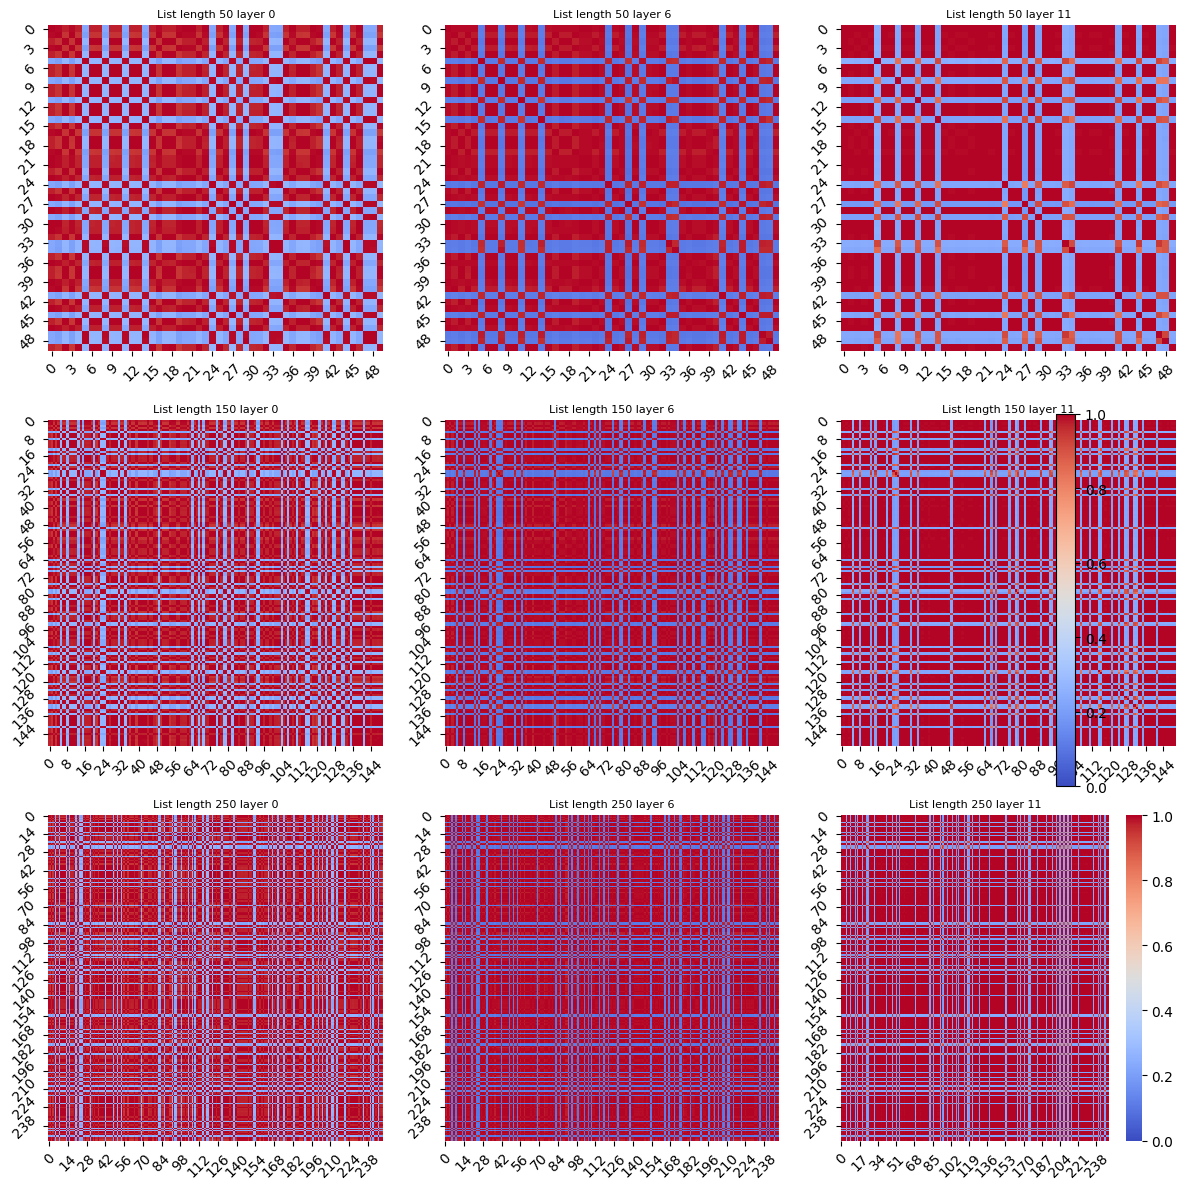

<Figure size 640x480 with 0 Axes>

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

# Set a common color map
cmap = 'coolwarm'  # You can use any colormap like 'viridis', 'plasma', etc.

# Set the color scale range for all plots (same vmin and vmax)
vmin = 0
vmax = 1

# Plot each heatmap on a different axis
sns.heatmap(correlation_matrix(actdict[0]["layer0"][:,-1,:]), ax=axes[0, 0], cmap=cmap, vmin=vmin, vmax=vmax, cbar=False)
axes[0, 0].set_title('List length 50 layer 0', fontsize=8)
sns.heatmap(correlation_matrix(actdict[0]["layer6"][:,-1,:]), ax=axes[0, 1], cmap=cmap, vmin=vmin, vmax=vmax, cbar=False)
axes[0, 1].set_title('List length 50 layer 6', fontsize=8)
sns.heatmap(correlation_matrix(actdict[0]["layer11"][:,-1,:]), ax=axes[0, 2], cmap=cmap, vmin=vmin, vmax=vmax, cbar=False)
axes[0, 2].set_title('List length 50 layer 11', fontsize=8)
sns.heatmap(correlation_matrix(actdict[2]["layer0"][:,-1,:]), ax=axes[1, 0], cmap=cmap, vmin=vmin, vmax=vmax, cbar=False)
axes[1, 0].set_title('List length 150 layer 0', fontsize=8)
sns.heatmap(correlation_matrix(actdict[2]["layer6"][:,-1,:]), ax=axes[1, 1], cmap=cmap, vmin=vmin, vmax=vmax, cbar=False)
axes[1, 1].set_title('List length 150 layer 6', fontsize=8)
sns.heatmap(correlation_matrix(actdict[2]["layer11"][:,-1,:]), ax=axes[1, 2], cmap=cmap, vmin=vmin, vmax=vmax, cbar=False)
axes[1, 2].set_title('List length 150 layer 11', fontsize=8)
sns.heatmap(correlation_matrix(actdict[4]["layer0"][:,-1,:]), ax=axes[2, 0], cmap=cmap, vmin=vmin, vmax=vmax, cbar=False)
axes[2, 0].set_title('List length 250 layer 0', fontsize=8)
sns.heatmap(correlation_matrix(actdict[4]["layer6"][:,-1,:]), ax=axes[2, 1], cmap=cmap, vmin=vmin, vmax=vmax, cbar=False)
axes[2, 1].set_title('List length 250 layer 6', fontsize=8)
sns.heatmap(correlation_matrix(actdict[4]["layer11"][:,-1,:]), ax=axes[2, 2], cmap=cmap, vmin=vmin, vmax=vmax)
axes[2, 2].set_title('List length 250 layer 11', fontsize=8)

# Add colorbars to each subplot
for ax in axes.flat:
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=45)

# Add a single colorbar to the figure
fig.colorbar(axes[2, 2].collections[0], ax=axes, orientation='vertical', fraction=0.02, pad=0.04)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()
plt.savefig("list_length.png")

In [ ]:
def correlation_matrix(W):
  """Computes a token-token correlation matrix."""
  W_flat = W.squeeze(0).detach().cpu().numpy()  # Shape: (tokens, hidden_dim)
  corr_mat = np.corrcoef(W_flat)  # Shape: (tokens, tokens)
  return torch.tensor(corr_mat, dtype=torch.float32)

#calculate plotting values
layer0y, layer6y, layer11y, layerfin = [],[],[],[]
for i in range(len(long_levels)):
  layer0y.append(torch.norm(correlation_matrix(actdict[i]["layer0"][:,-1,:]), p="fro"))
  layer6y.append(torch.norm(correlation_matrix(actdict[i]["layer6"][:,-1,:]), p="fro"))
  layer11y.append(torch.norm(correlation_matrix(actdict[i]["layer11"][:,-1,:]), p="fro"))
  layerfin.append(torch.norm(correlation_matrix(actdict[i]["finlayer"][:,-1,:]), p="fro"))

import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x = long_levels, y=layer0y, mode="lines", name="Layer 0"))
fig.add_trace(go.Scatter(x=long_levels, y=layer6y, mode="lines", name="Layer 6"))
fig.add_trace(go.Scatter(x=long_levels, y=layer11y, mode="lines", name="Layer 11"))
fig.add_trace(go.Scatter(x=long_levels, y=layerfin, mode="lines", name="Layer output"))

fig.update_layout(
    title="MLP output on long tokens",
    xaxis_title="laundry list length",
    yaxis_title="norm of MLP correlation",
    legend_title="Layers",
    height=500, width=700
)

# Show figure
pio.show(fig)

# Experiment 4

This experiment is towards verifying the linearity of embeddings from th language model. Will be using a pretrained-SAE by [Identifying Functionally Important Features with
End-to-End Sparse Dictionary Learning](https://github.com/ApolloResearch/e2e_sae)


The idea is: For every layer (or 0,6,11 like in the first experiment), take the activations from MLP layer just after the attention layer, check each of their correlation with the hidden layer representation of the SAE with increasing sparsity.

For 100 tokens \\
For 500 tokens \\





In [ ]:
!pip install e2e_sae

In [ ]:
#train a small e2e encoder and compare with svd
